# k-Nearest Neighbors

In [110]:
# Import required libraries
import hashlib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [111]:
# Using SHA-256 to generate unique seed
username = "m.samartha"
seed = int( hashlib.sha256(username.encode()).hexdigest(),16) % (2**32)
print(seed)

2669878649


In [112]:
# Load dataset
df = pd.read_csv("student-dataset.csv")
print(df)

      Gender   Major Program   GPA
0       Male  B.Tech     CHD  6.65
1       Male  B.Tech     CSE  7.05
2     Female  B.Tech     CSE  7.67
3       Male  B.Tech     ECE  8.89
4       Male  B.Tech     ECE  6.35
...      ...     ...     ...   ...
9995    Male  B.Tech     ECE  5.82
9996  Female  B.Tech     ECE  7.72
9997    Male     PhD     CHD  7.68
9998    Male  B.Tech     ECE  7.61
9999    Male     PhD     ECE  8.26

[10000 rows x 4 columns]


## Preprocessing

In [113]:
class PerFeatureTransformer:
    def __init__(self):
        """Initializes memory for per-feature transformers"""
        self.transformers = {}
        self.params = {}

    def fit(self, df: pd.DataFrame, params: dict[str, str]) -> None:
        """Fits transformers for each feature based on the given type"""
        self.params = params
        for feature, transform_type in params.items():
            if transform_type == "standard":
                transformer = StandardScaler()
                transformer.fit(df[[feature]])
            elif transform_type == "onehot":
                transformer = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
                transformer.fit(df[[feature]])
            elif transform_type == "ordinal":
                # Explicit ordering for Major
                categories = [["B.Tech", "MS", "PhD"]]
                transformer = OrdinalEncoder(categories=categories)
                transformer.fit(df[[feature]])
            else:
                raise ValueError(f"Unknown transformation type: {transform_type}")
            
            self.transformers[feature] = transformer

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        """Applies the fitted transformers to the corresponding features and returns a NumPy array"""
        transformed_features = []
        for feature, transformer in self.transformers.items():
            transformed = transformer.transform(df[[feature]])
            transformed_features.append(transformed)
        
        return np.hstack(transformed_features)

    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        """Fits and transforms all features in one step using the given transformation parameters"""
        self.fit(df, params)
        return self.transform(df)
    
# Testing
Transformer = PerFeatureTransformer()
params = {
    "GPA": "standard",
    "Major" : "ordinal",
    "Program" : "onehot"
}
Transformed = Transformer.fit_transform(df, params)
print("Size = ", Transformed.shape)
print(Transformed)




Size =  (10000, 6)
[[-0.6399333   0.          1.          0.          0.          0.        ]
 [-0.25390343  0.          0.          0.          1.          0.        ]
 [ 0.34444287  0.          0.          0.          1.          0.        ]
 ...
 [ 0.35409362  2.          1.          0.          0.          0.        ]
 [ 0.28653839  0.          0.          0.          0.          1.        ]
 [ 0.91383694  2.          0.          0.          0.          1.        ]]


#### Observations
From the above cell output, we have verified the pre-processing steps such as applying StandardScaler, OneHot and Ordinal encoders. We see that the first column represeting GPA is between -1 and 1. Moreover the 2nd column representing Major has been ordinally encoded with values ranging from 0 to 2. The last 4 columns representing Programs have been one-hot encoded with binary values (0 or 1).


## Prediction

In [114]:
class KNNGenderPredictor:
    def __init__(self, student_df: pd.DataFrame, username: str, seed: int):
        """Initializes with dataset and username for plots."""
        self.student_df = student_df
        self.username = username
        self.transformer = PerFeatureTransformer()
        self.label_encoder = LabelEncoder()
        self.seed = seed

        # Define default transformations for features
        self.params = {
            "GPA": "standard",
            "Major": "ordinal",
            "Program": "onehot"
        }

    def train_val_test_split(self, seed: int, test_size: float = 0.2, val_size: float = 0.2):
        """Split into train, validation, and test sets."""
        train_df, test_df = train_test_split(self.student_df, test_size=test_size, 
                                             stratify=self.student_df["Gender"], 
                                             random_state=seed)
        # Adjust val_size for the reduced train_df
        val_size = val_size / (1 - test_size)  

        train_df, val_df = train_test_split(train_df, test_size=val_size, 
                                            stratify=train_df["Gender"], 
                                            random_state=seed)
        
        self.train_df, self.val_df, self.test_df = train_df, val_df, test_df
        return train_df, val_df, test_df

    def get_feature_matrix_and_labels(self, df: pd.DataFrame, features: list[str], fit: bool = False):
        """
        Prepares feature matrix X and label vector y.
        If fit=True, it will fit the transformers and label encoder on the given df (for train_df)
        Otherwise, it will just transform using already fitted ones (for val_df and test_df)
        """
        if fit:
            X = self.transformer.fit_transform(df[features], self.params)
            self.label_encoder.fit(df["Gender"])
        else:
            X = self.transformer.transform(df[features])
        y = self.label_encoder.transform(df["Gender"])
        return X, y

    def get_knn_accuracy_vs_k(self, k_values: list[int], distance: str = "euclidean"):
        """Compute validation accuracy for different k values"""
        features = list(self.params.keys())

        X_train, y_train = self.get_feature_matrix_and_labels(self.train_df, features, fit=True)
        X_val, y_val = self.get_feature_matrix_and_labels(self.val_df, features)

        accuracies = []
        for k in k_values:
            model = KNeighborsClassifier(n_neighbors=k, metric=distance) #Define Model
            model.fit(X_train, y_train) #Train Model
            y_pred = model.predict(X_val) #Predict Validation Set
            accuracies.append(accuracy_score(y_val, y_pred)) #Compute Accuracy
        return accuracies

    def plot_knn_accuracy_vs_k(self, k_values: list[int], distance: str = "euclidean"):
        """Plot validation accuracy vs k."""
        accuracies = self.get_knn_accuracy_vs_k(k_values, distance)
        # convert to percentage
        accuracies = [acc * 100 for acc in accuracies]
        plt.figure(figsize=(6, 4))
        plt.scatter(k_values, accuracies, color="blue", marker="o", label="Accuracy")
        plt.plot(k_values, accuracies, color="blue", linestyle="--", alpha=0.7)
        plt.xticks(k_values)
        plt.xlabel("k (neighbors)", fontsize = 12)
        plt.ylabel("Validation Accuracy (%)", fontsize = 12)
        plt.title(f"k-NN Accuracy ({distance}) - {self.username}", fontsize = 14)
        print("Max Accuracy = ", round(max(accuracies), 2) , "at k = ", k_values[accuracies.index(max(accuracies))])
        plt.show()

    def get_knn_f1_heatmap(self, k_values: list[int], distances: list[str]) -> pd.DataFrame:
        """Return DataFrame of F1 scores for (k, distance) combinations."""
        features = list(self.params.keys())
        X_train, y_train = self.get_feature_matrix_and_labels(self.train_df, features, fit=True)
        X_val, y_val = self.get_feature_matrix_and_labels(self.val_df, features)

        results = []
        for dist in distances:
            # row contains F1 scores for each k for the given distance
            row = []
            for k in k_values:
                model = KNeighborsClassifier(n_neighbors=k, metric=dist)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                row.append(f1_score(y_val, y_pred, average="weighted"))
            results.append(row)

        df_scores = pd.DataFrame(results, index=distances, columns=k_values)
        return df_scores

    def plot_knn_f1_heatmap(self, k_values: list[int], distances: list[str]):
        """Plot line graph and heatmap of F1 scores for (k, distance)."""
        f1_df = self.get_knn_f1_heatmap(k_values, distances)

        # Line plot of F1 vs k for each distance
        plt.figure(figsize=(8, 5))
        for dist in distances:
            plt.plot(k_values, f1_df.loc[dist], marker="o", label=dist, color=plt.cm.viridis(distances.index(dist) / len(distances)))
        plt.xlabel("k values", fontsize=12)
        plt.ylabel("F1 Score", fontsize=12)
        plt.title(f"k-NN F1 Score vs k - {self.username}", fontsize=14)
        plt.legend(title="Distance Metric")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.show()

        # Heatmap of F1 scores
        plt.figure(figsize=(8, 5))
        sns.heatmap(f1_df, annot=True, cmap="viridis", fmt=".3f")
        plt.xlabel("k values", fontsize=12)
        plt.ylabel("Distance metric", fontsize=12)
        plt.title(f"k-NN F1 Score Heatmap - {self.username}", fontsize=14)
        plt.show()

    def get_knn_f1_single_feature_table(self, k_values: list[int], features: list[str], 
                                        distance: str = "euclidean") -> pd.DataFrame:
        """Table of F1 scores on Test DF using only one feature at a time."""
        scores = {}
        for feature in features:
            # Fit transformer only for single feature
            transformer = PerFeatureTransformer()
            transformer.fit(self.train_df[[feature]], {feature: self.params[feature]})
            self.label_encoder.fit(self.train_df["Gender"])

            X_train = transformer.transform(self.train_df[[feature]])
            X_test = transformer.transform(self.test_df[[feature]])

            y_train = self.label_encoder.transform(self.train_df["Gender"])
            y_test = self.label_encoder.transform(self.test_df["Gender"])

            feature_scores = []
            for k in k_values:
                model = KNeighborsClassifier(n_neighbors=k, metric=distance)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                feature_scores.append(f1_score(y_test, y_pred, average="weighted"))
            scores[feature] = feature_scores

        return pd.DataFrame(scores, index=k_values)
    

In [115]:
Predictor = KNNGenderPredictor(df, "m.samartha", seed)
train_df, val_df, test_df = Predictor.train_val_test_split(seed)

max_k = 21
k_values = list(range(1, max_k + 2, 2))

Max Accuracy =  62.05 at k =  21


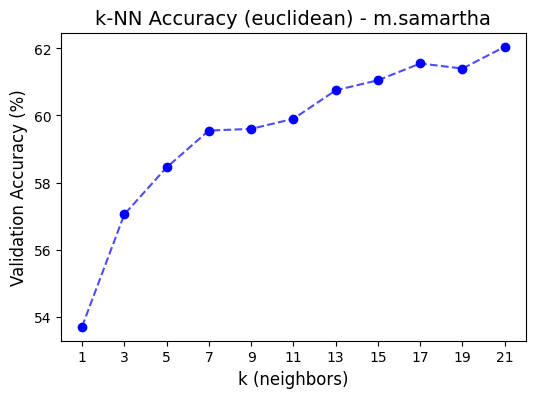

Max Accuracy =  62.0 at k =  21


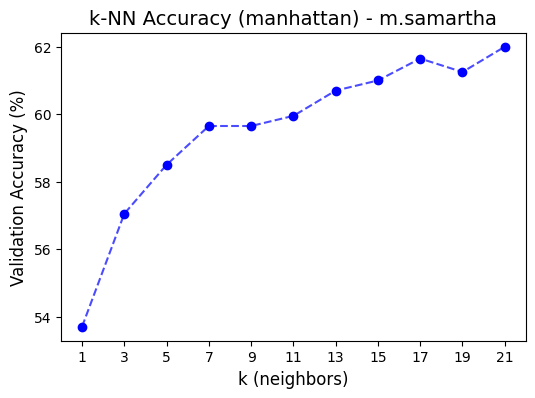

Max Accuracy =  62.3 at k =  21


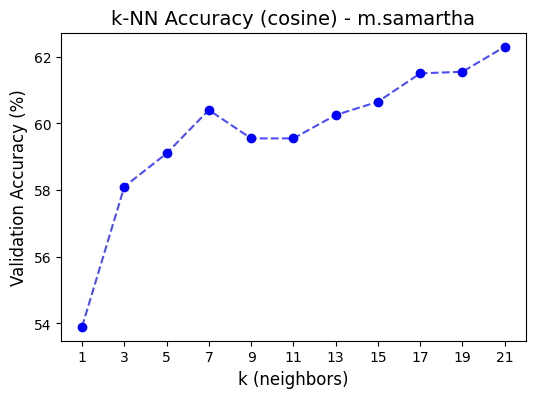

In [116]:
Predictor.plot_knn_accuracy_vs_k(k_values=k_values, distance="euclidean")
Predictor.plot_knn_accuracy_vs_k(k_values=k_values, distance="manhattan")
Predictor.plot_knn_accuracy_vs_k(k_values=k_values, distance="cosine")

#### Observations
K = 21 performed the best and gave the highest accuracy among all the distance metrics. This is because with a higher K, we analyze more neighbors, which helps in making better predictions. Moreover, the accuracies were very similar for all the distance metrics and mostly increase montonously with increase in K.

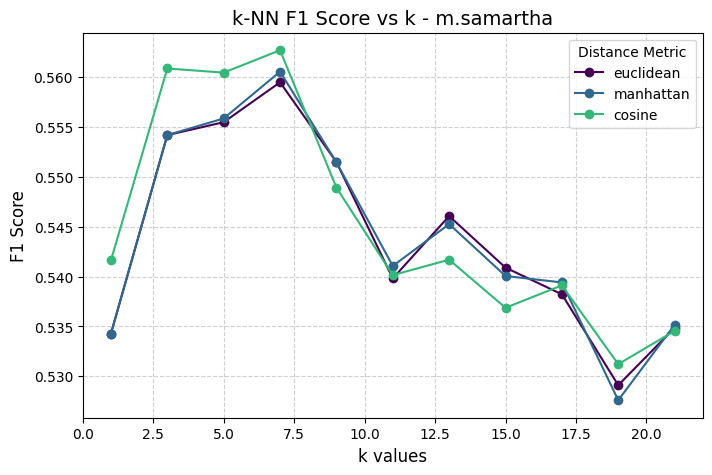

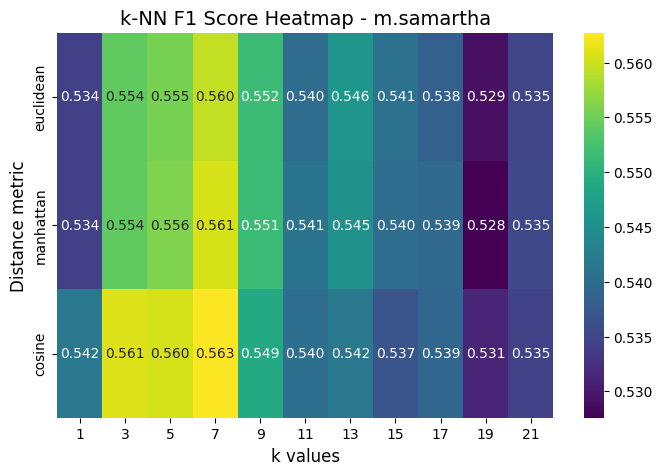

In [117]:
Predictor.plot_knn_f1_heatmap(k_values=k_values, 
                              distances=["euclidean", "manhattan", "cosine"])

#### Observation
Here cosine distance metric performed better than others in terms of F1 score. Its highest F1-score is with k = 7 and is 0.563. The reason this metric performs better is because it takes into account the angle between the vectors, rather than their magnitude. This makes it more effective in high-dimensional spaces where the data may be sparse. Whereas Euclidean and Manhattan distance metrics are more affected by the magnitude of the vectors, which can be misleading in such cases. Hence in general, for categorical features cosine performs better that the other two.

In [ ]:
features = ['Major', 'Program', 'GPA']
f1_single_feature = [None] * 3
f1_single_feature[0] = Predictor.get_knn_f1_single_feature_table(k_values=k_values, 
                                           features=features, 
                                           distance="euclidean")
f1_single_feature[1] = Predictor.get_knn_f1_single_feature_table(k_values=k_values,
                                           features=features,
                                           distance="manhattan")
f1_single_feature[2] = Predictor.get_knn_f1_single_feature_table(k_values=k_values,
                                           features=features,
                                           distance="cosine")

# Printing every other row so as to fit into the output (can be changed as required)

print("Single Feature (Euclidean)")
print(f1_single_feature[0].iloc[::2])
print("")

print("Single Feature (Manhattan)")
print(f1_single_feature[1].iloc[::2])
print("")

print("Single Feature (Cosine)")
print(f1_single_feature[2].iloc[::2])
print("")

Single Feature (Euclidean)
      Major   Program       GPA
1   0.51719  0.550811  0.545101
5   0.51719  0.517190  0.559472
9   0.51719  0.544704  0.558453
13  0.51719  0.517190  0.552761
17  0.51719  0.517190  0.543698
21  0.51719  0.517190  0.544066

Single Feature (Manhattan)
      Major   Program       GPA
1   0.51719  0.550811  0.545101
5   0.51719  0.517190  0.559472
9   0.51719  0.544704  0.558453
13  0.51719  0.517190  0.552761
17  0.51719  0.517190  0.543698
21  0.51719  0.517190  0.544066

Single Feature (Cosine)
      Major  Program       GPA
1   0.51719  0.51719  0.356833
5   0.51719  0.51719  0.517190
9   0.51719  0.51719  0.517190
13  0.51719  0.51719  0.517190
17  0.51719  0.51719  0.517190
21  0.51719  0.51719  0.517190



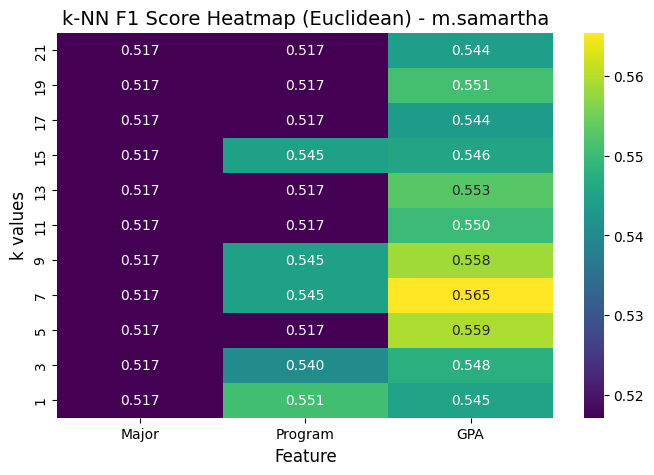

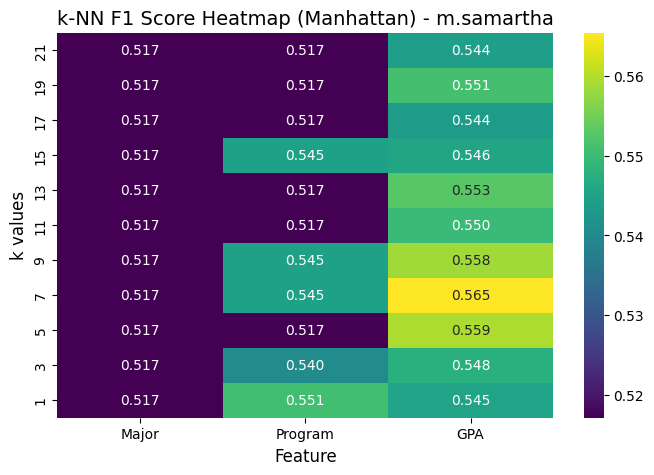

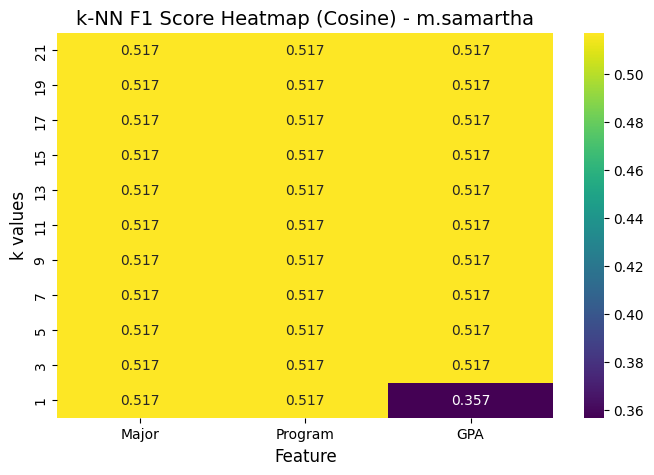

In [123]:
# Plot heatmap
 
# Euclidean
plt.figure(figsize=(8, 5))
sns.heatmap(f1_single_feature[0].iloc[::-1], annot=True, cmap="viridis", fmt=".3f")
plt.xlabel("Feature", fontsize = 12)
plt.ylabel("k values", fontsize = 12)
plt.title(f"k-NN F1 Score Heatmap (Euclidean) - {username}", fontsize = 14)
plt.show()

# Manhattan
plt.figure(figsize=(8, 5))
sns.heatmap(f1_single_feature[1].iloc[::-1], annot=True, cmap="viridis", fmt=".3f")
plt.xlabel("Feature", fontsize = 12)
plt.ylabel("k values", fontsize = 12)
plt.title(f"k-NN F1 Score Heatmap (Manhattan) - {username}", fontsize = 14)
plt.show()

# Cosine
plt.figure(figsize=(8, 5))
sns.heatmap(f1_single_feature[2].iloc[::-1], annot=True, cmap="viridis", fmt=".3f")
plt.xlabel("Feature", fontsize = 12)
plt.ylabel("k values", fontsize = 12)
plt.title(f"k-NN F1 Score Heatmap (Cosine) - {username}", fontsize = 14)
plt.show()

#### Observation
GPA clearly performed the best compared to other features when only one feature is used. This is because the model is able to capture the nuances of the data more effectively with a single, continuous variable rather than multiple categorical variables. The F1 scores for GPA are consistently higher across all distance metrics and k values, indicating that it is the most informative feature for this task. The other categorical features- Major and Program don't embed any information about the gender, whereas GPA is likely correlated with the gender.

Talking about distance metrics in single feature analysis, we see that Euclidean and Manhattan outperform the cosine metric. This is because, as said earlier, the former metrics are good at capturing the magnitude of the vectors, which is more relevant in the case of a single continuous feature like GPA. Moreover in the third heatmap above corresponding to cosine metric, we see that the F-1 score is much lesser in the GPA standalone feature, and is equal to that of Major and Program.

The F-1 score with GPA standalone feature with either Euclidean/Manhattan is almost equal and in some cases better than the ones with all the features. This is again because GPA capture most of the relavant info about the gender and the other two categorical features do not contribute much in this regard.